In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy as sp
import cv2
import sys
import seaborn as sns

from skimage.data import shepp_logan_phantom
from skimage.transform import (radon, rescale, iradon)
from skimage.restoration import (denoise_bilateral, calibrate_denoiser, denoise_nl_means,
                                 denoise_tv_bregman, denoise_tv_chambolle, denoise_wavelet, estimate_sigma)
from skimage.util import (img_as_float, random_noise)
from skimage.color import rgb2gray
from skimage.metrics import peak_signal_noise_ratio as peakSNR
from skimage.io import use_plugin, imread, imsave, find_available_plugins, imshow

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
find_available_plugins()

{'fits': ['imread', 'imread_collection'],
 'gdal': ['imread', 'imread_collection'],
 'gtk': ['imshow'],
 'imageio': ['imread', 'imsave', 'imread_collection'],
 'imread': ['imread', 'imsave', 'imread_collection'],
 'matplotlib': ['imshow', 'imread', 'imshow_collection', 'imread_collection'],
 'pil': ['imread', 'imsave', 'imread_collection'],
 'qt': ['imshow', 'imsave', 'imread', 'imread_collection'],
 'simpleitk': ['imread', 'imsave', 'imread_collection'],
 'tifffile': ['imread', 'imsave', 'imread_collection']}

Importing using cv2

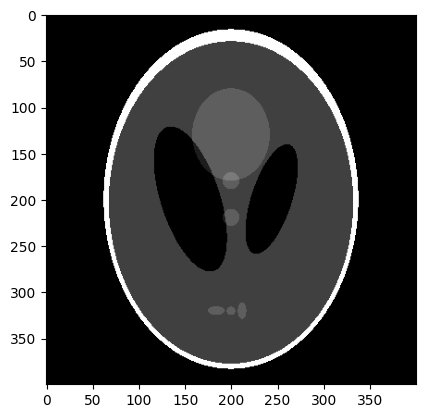

In [5]:
image = shepp_logan_phantom()
plt.imshow(image, cmap=plt.cm.Greys_r)

In [6]:
print(f'slice_3um - dtype: {image.dtype}, shape: {image.shape}, min: {np.min(image)}, max: {np.max(image)}')
# image

slice_3um - dtype: float64, shape: (400, 400), min: 0.0, max: 1.0


(200,)
sinogram shape = (400, 200)


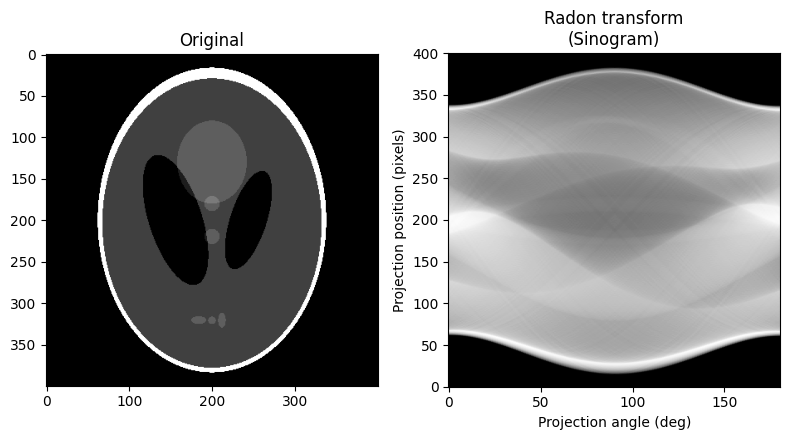

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0.0, 180.0, max(image.shape), endpoint=False)[::2]
print(theta.shape)
sinogram = radon(image, theta=theta)
print(f"sinogram shape = {sinogram.shape}")
dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(
    sinogram,
    cmap=plt.cm.Greys_r,
    extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
    aspect='auto',
)

fig.tight_layout()
plt.show()

FBP rms reconstruction error: 0.0333


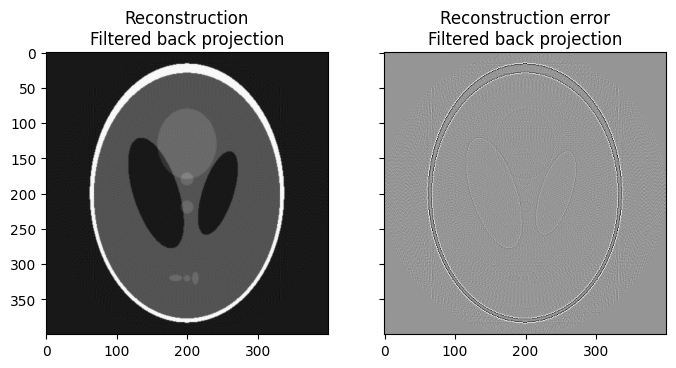

In [8]:
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - image
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5), sharex=True, sharey=True)
ax1.set_title("Reconstruction\nFiltered back projection")
ax1.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax2.set_title("Reconstruction error\nFiltered back projection")
ax2.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

In [10]:
# slice_3um = cv2.imread('test_imgs\slice_3um.tif', cv2.IMREAD_UNCHANGED)
slice_5um = cv2.imread(r'data_5um\proj\17_01_2024_P2_B2_CONTROL00000000.tif', cv2.IMREAD_UNCHANGED)
# rec_slice_3p5um = cv2.imread(r'test_imgs\reconstructed_slice_2d.bmp', cv2.IMREAD_UNCHANGED)

# print(f'slice_3um - dtype: {slice_3um.dtype}, shape: {slice_3um.shape}, min: {np.min(slice_3um)}, max: {np.max(slice_3um)}')
print(f'slice_5um - dtype: {slice_5um.dtype}, shape: {slice_5um.shape}, min: {np.min(slice_5um)}, max: {np.max(slice_5um)}')
# print(f'rec_slice_3p5um - dtype: {rec_slice_3p5um.dtype}, shape: {rec_slice_3p5um.shape}, min: {np.min(rec_slice_3p5um)}, max: {np.max(rec_slice_3p5um)}')

slice_5um - dtype: uint16, shape: (2688, 4032), min: 22961, max: 64080


Importing using skimage directly

In [15]:
# slice_3um_skimage = imread('test_imgs\slice_3um.tif', plugin='pil') # imread_collection después
slice_5um_skimage = imread(r'data_5um\proj\17_01_2024_P2_B2_CONTROL00000000.tif', plugin='pil')
amin = np.min(slice_5um_skimage)
amax = np.max(slice_5um_skimage)
# rec_slice_3p5um_skimage = imread(r'test_imgs\reconstructed_slice_2d.bmp', plugin='pil')

# print(f'slice_3um - dtype: {slice_3um_skimage.dtype}, shape: {slice_3um_skimage.shape}, min: {np.min(slice_3um_skimage)}, max: {np.max(slice_3um_skimage)}')
print(f'slice_5um - dtype: {slice_5um_skimage.dtype}, shape: {slice_5um_skimage.shape}, min: {amin}, max: {amax}')
# print(f'rec_slice_3p5um - dtype: {rec_slice_3p5um_skimage.dtype}, shape: {rec_slice_3p5um_skimage.shape}, min: {np.min(rec_slice_3p5um_skimage)}, max: {np.max(rec_slice_3p5um_skimage)}')

slice_5um - dtype: uint16, shape: (2688, 4032), min: 22961, max: 64080


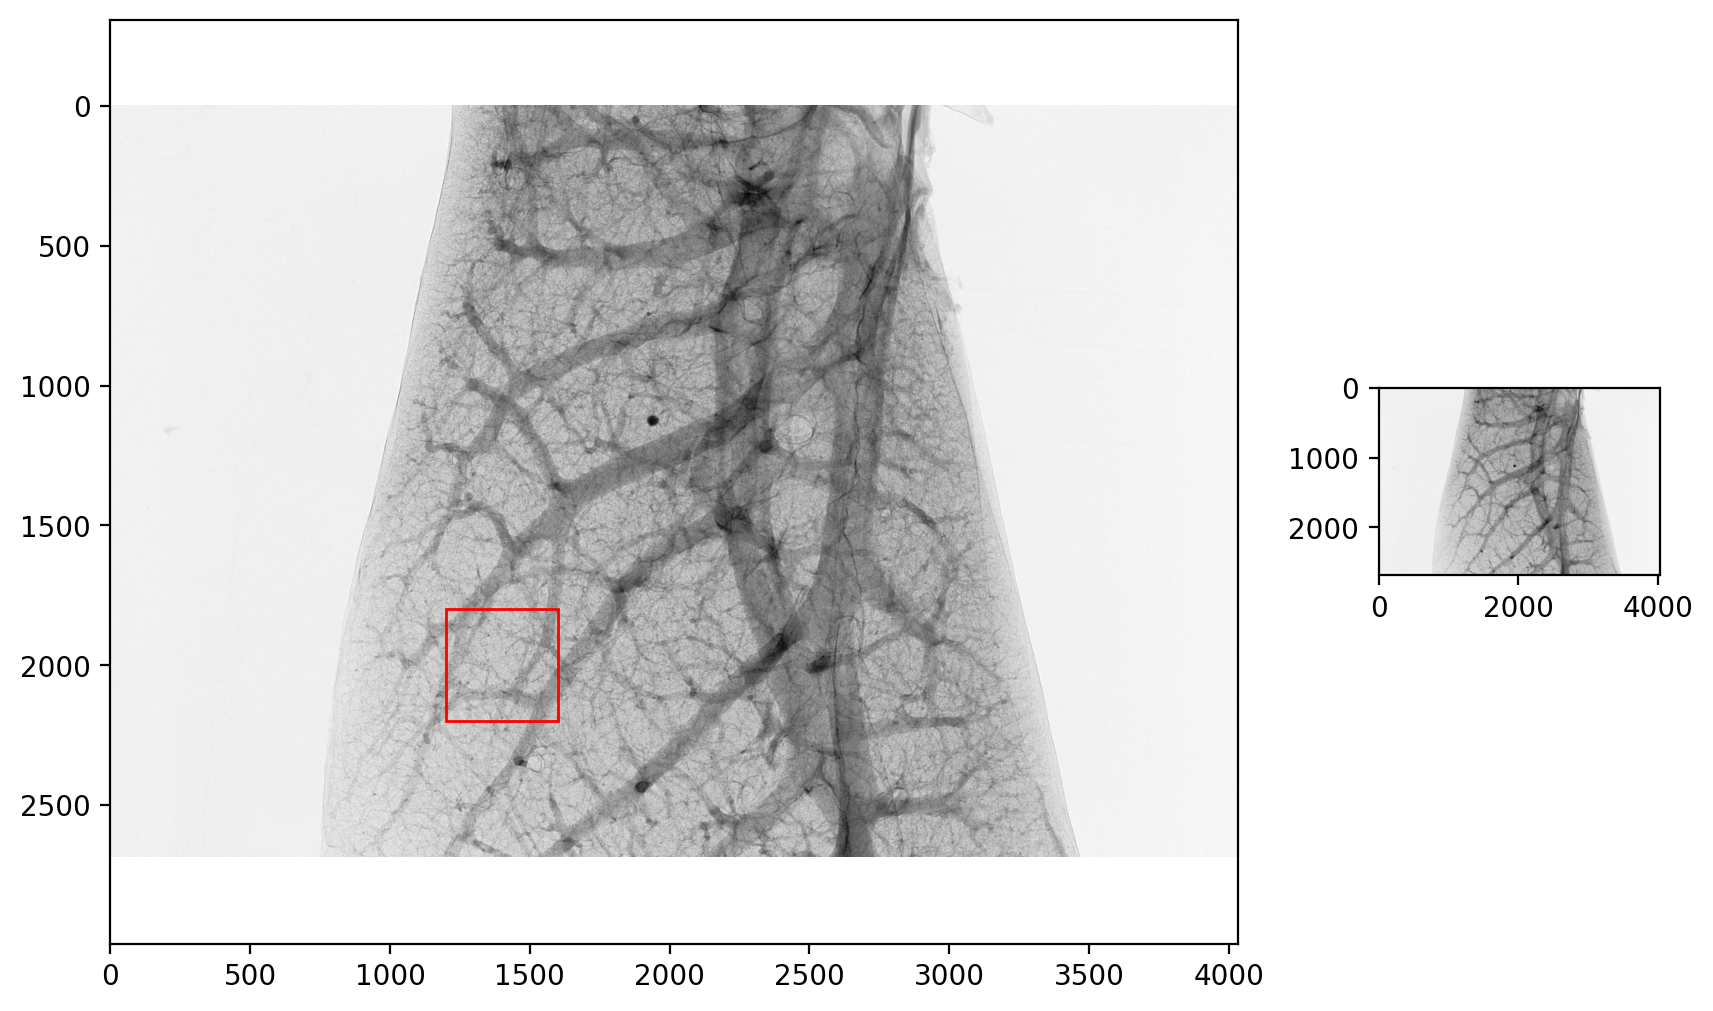

In [16]:
vertex = (1200, 1800)
width = 400
slice_5um_sample = slice_5um_skimage[vertex[1]:vertex[1]+width, vertex[0]:vertex[0]+width]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), dpi=200, gridspec_kw={'width_ratios': [4, 1]})
ax1.imshow(slice_5um, cmap=plt.cm.Greys_r, vmin=amin, vmax=amax)
ax1.axis("equal")
rect = patches.Rectangle(vertex, width, width, linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax2.imshow(slice_5um, cmap=plt.cm.Greys_r, vmin=amin, vmax=amax)

plt.show()

Slice testing - 5um

In [17]:
import algotom.io.converter as cvr
proj_path = r".\data_5um\proj"

output_base = r".\data_5um"

# Convert tif images to hdf format for fast extracting sinograms.
file_path = output_base + "/tmp_/" + "5um_data.hdf"
key_path = "entry/projections"
cvr.convert_tif_to_hdf(proj_path, file_path, key_path=key_path)

'.\\data_5um/tmp_/5um_data.hdf'

In [13]:
Nimgs = 1800
idx_slice = 1200

all_thumbnails = []

# Radon transform of u data (sinogram), noisy
Ru = np.zeros((Nimgs, slice_5um_skimage.shape[1]))

for i in range(Nimgs):
    if i % 200 == 0:
        print(f"Current slice: {i}")
    
    current_proj = cv2.imread(r'.\PS2_B2_CT_images_raw\17_01_2024_P2_B2_CONTROL0000' + f"{i:04}" + '.tif', cv2.IMREAD_UNCHANGED)
    Ru[i, :] = current_proj[idx_slice, :]
    # all_thumbnails.append(rescale(current_proj, 0.4))

Ru = Ru.T

Current slice: 0
Current slice: 200


KeyboardInterrupt: 

In [ ]:
print(Nimgs)

1800


In [ ]:
Ru.shape

(4032, 1800)

In [ ]:
mins = []


sect_samples_orig = []
sect_samples_mid = []

for i in range(20,100):

    id_mid = len(all_thumbnails)//2 + i

    fig, ax = plt.subplots(figsize=(8,6), dpi=200)
    # cv2.filter2D(all_thumbnails[0], -1, np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]))
    ax.imshow(all_thumbnails[0], cmap=plt.cm.Greys_r, vmin=0, vmax=1) # [roi_bot:roi_top, roi_left:roi_right]
    ax.imshow(np.flip(all_thumbnails[id_mid], axis=1), cmap=plt.cm.Blues, vmin=0, vmax=1, alpha=0.5)
    # mins.append(np.linalg.norm((all_thumbnails[0] - np.flip(all_thumbnails[id_mid], axis=1)).reshape(-1, 1)))

    ax.axis("equal")
    ax.set_title(f"{i}")
    # rect = patches.Rectangle(vertex, width, width, linewidth=1, edgecolor='r', facecolor='none')
    # ax1.add_patch(rect)
    # ax2.imshow(slice_5um_sample, cmap='gray', vmin=24352, vmax=65535)

    plt.show()

    sect_samples_orig.append(all_thumbnails[0][100, :])
    sect_samples_mid.append(np.flip(all_thumbnails[id_mid], axis=1)[100, :])

    
fig, ax = plt.subplots(figsize=(7,4), dpi=200)
cpar = sns.color_palette("Reds", len(sect_samples_mid))
cpab = sns.color_palette("Blues", len(sect_samples_orig))
print(len(cpar))
print(len(cpab))
ax.plot(sect_samples_orig[0], color="blue")
for i in range(len(sect_samples_mid)):
    ax.plot(sect_samples_mid[i], color=cpar[i])

plt.show()
# plt.plot(mins)

NameError: name 'all_thumbnails' is not defined

In [ ]:
all_thumbnails = np.asarray(all_thumbnails)

In [ ]:
all_thumbnails.shape

(1800, 269, 403)

In [ ]:
def images_to_video(images, output_path, fps=120):
    # if not images:
    #     print("No images to write.")
    #     return
    
    amax = np.max([np.max(img) for img in images])
    print(amax)
    amin = np.min([np.min(img) for img in images])
    print(amin)

    height, width = images[0].shape
    for img in images:
        if img.shape != (height, width):
            print("All images must have the same dimensions.")
            return

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    if not out.isOpened():
        print("Error: VideoWriter not opened.")
        return

    for img in images:
        # print(img[:5,:5])
        img = (img - amin) / (amax - amin) # x - min / max - min

        difs = []
        colavg = 0
        for i in range(img.shape[1]):
            colavg_c = np.mean(img[:, i])
            if colavg != 0:
                dif = colavg_c - colavg
                # print(dif)
                difs.append(dif)
                if np.abs(dif) > 0.002:
                    img[:, i] = 0.0
                    
                    break
            colavg = colavg_c 
        # plt.plot(difs)
        img[:, img.shape[1]//2] = 1.0
        img = (img * 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        out.write(img_bgr)

    out.release()
    print(f"Video saved at {output_path}")

# Example usage:
# images = [img1, img2, img3, ...] # List of numpy arrays representing grayscale images
# images_to_video(images, 'output_video.mp4', fps=30)

In [ ]:
# Example with dummy grayscale images
images = [np.random.randint(0, 10000, (480, 640)) for _ in range(30)]  # 30 random grayscale frames of size 640x480
images_to_video(images, 'output_video.mp4', fps=30)

9999
0
[[5689 4502 3941 8477 4729]
 [9978   12 2092 1116 8962]
 [9828 6239 7809 9431 4128]
 [1037 5705 3790 9761 8886]
 [3326  601 4650 6110 1692]]
[[6738 8575 8104 1896 8775]
 [2562 8383 7756 5901 6190]
 [6626 2605  267 6873 8034]
 [5926 4118 9326 6536 8263]
 [3983 1941 2990   21 3290]]
[[4688 3682 5917 6691 3370]
 [5028 7347 2011 5293 1770]
 [6832 2244 6270 6461 1392]
 [ 592 7686 2953 5981 6838]
 [7835 5234 3441 5618 3837]]
[[7265 6639 8631 6660 8595]
 [8316 1993  677 8465 2568]
 [1905 9302 8870 9278 1620]
 [6763 8154 9947 7652 9480]
 [ 608 2572 5728 3153 5981]]
[[ 366 1297 4723  577 9482]
 [9250 9629 8637 4462 8053]
 [1480  660 4249 9157  349]
 [5965 3745 8511 1603 3516]
 [5763 5754 6445 3378 7820]]
[[9759 1380 4258 2418 7952]
 [3420 8377 2455 6584 5171]
 [3556 8558 1407 9955 1189]
 [3075 1791 3864 2958 8607]
 [5439 7909 5790 3622 6904]]
[[3793 8821 7762 9673 5362]
 [9016  480 9908   31 3789]
 [8791 7301 3519  731 5873]
 [2075 2969 2921 8171 1010]
 [  52 4726 6570 2035 7893]]
[[9477

In [ ]:
all_thumbnails[0].dtype

dtype('float64')

In [ ]:
images_to_video(all_thumbnails, "out.mp4")
# plt.show()

0.9872810119765509
0.24272283336918682
Video saved at out.mp4


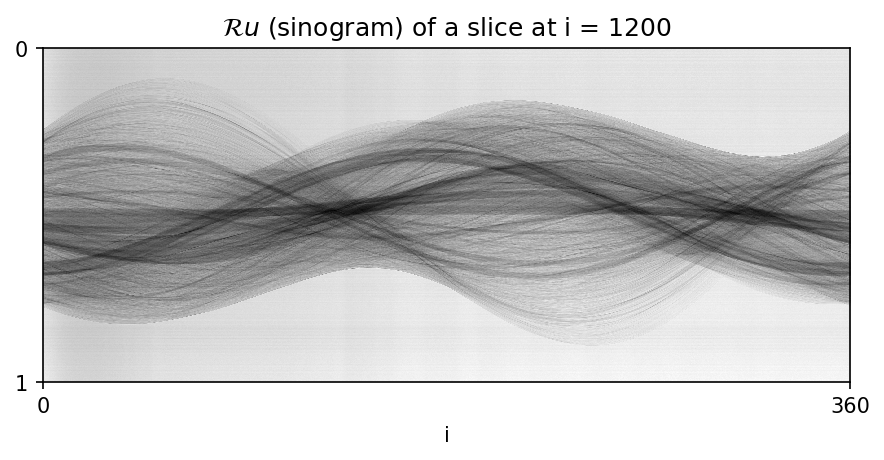

In [ ]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
ax.imshow(Ru, cmap='gray', interpolation='nearest', aspect='auto')
ax.set(xticks=[0, 1800], xticklabels=[0, 360], yticks=[0, slice_3um_skimage.shape[1]], yticklabels=[0, 1])
ax.set_xlabel("i")
plt.tight_layout()
plt.title(r"$\mathcal{R}u$ (sinogram) of a slice at i = " + f"{idx_slice}")
plt.show()

In [ ]:
Ru.shape

(4032, 1800)

In [ ]:
idtheta_half = Ru.shape[1]//2
np.arange(0, 180, 0.2)

array([  0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,
         1.8,   2. ,   2.2,   2.4,   2.6,   2.8,   3. ,   3.2,   3.4,
         3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,
         5.4,   5.6,   5.8,   6. ,   6.2,   6.4,   6.6,   6.8,   7. ,
         7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,
         9. ,   9.2,   9.4,   9.6,   9.8,  10. ,  10.2,  10.4,  10.6,
        10.8,  11. ,  11.2,  11.4,  11.6,  11.8,  12. ,  12.2,  12.4,
        12.6,  12.8,  13. ,  13.2,  13.4,  13.6,  13.8,  14. ,  14.2,
        14.4,  14.6,  14.8,  15. ,  15.2,  15.4,  15.6,  15.8,  16. ,
        16.2,  16.4,  16.6,  16.8,  17. ,  17.2,  17.4,  17.6,  17.8,
        18. ,  18.2,  18.4,  18.6,  18.8,  19. ,  19.2,  19.4,  19.6,
        19.8,  20. ,  20.2,  20.4,  20.6,  20.8,  21. ,  21.2,  21.4,
        21.6,  21.8,  22. ,  22.2,  22.4,  22.6,  22.8,  23. ,  23.2,
        23.4,  23.6,  23.8,  24. ,  24.2,  24.4,  24.6,  24.8,  25. ,
        25.2,  25.4,

In [ ]:
from skimage.transform import iradon

idtheta_half = Ru.shape[1]//2
print(idtheta_half)

RinvRu = iradon(Ru[:, :idtheta_half], theta= np.arange(0, 180, 0.2))

900


KeyboardInterrupt: 

In [ ]:
from skimage.transform import iradon_sart

RinvRu_sart = iradon_sart(Ru[:, :idtheta_half], theta= np.arange(0, 180, 0.2))

In [ ]:
RinvRu.shape

(4032, 4032)

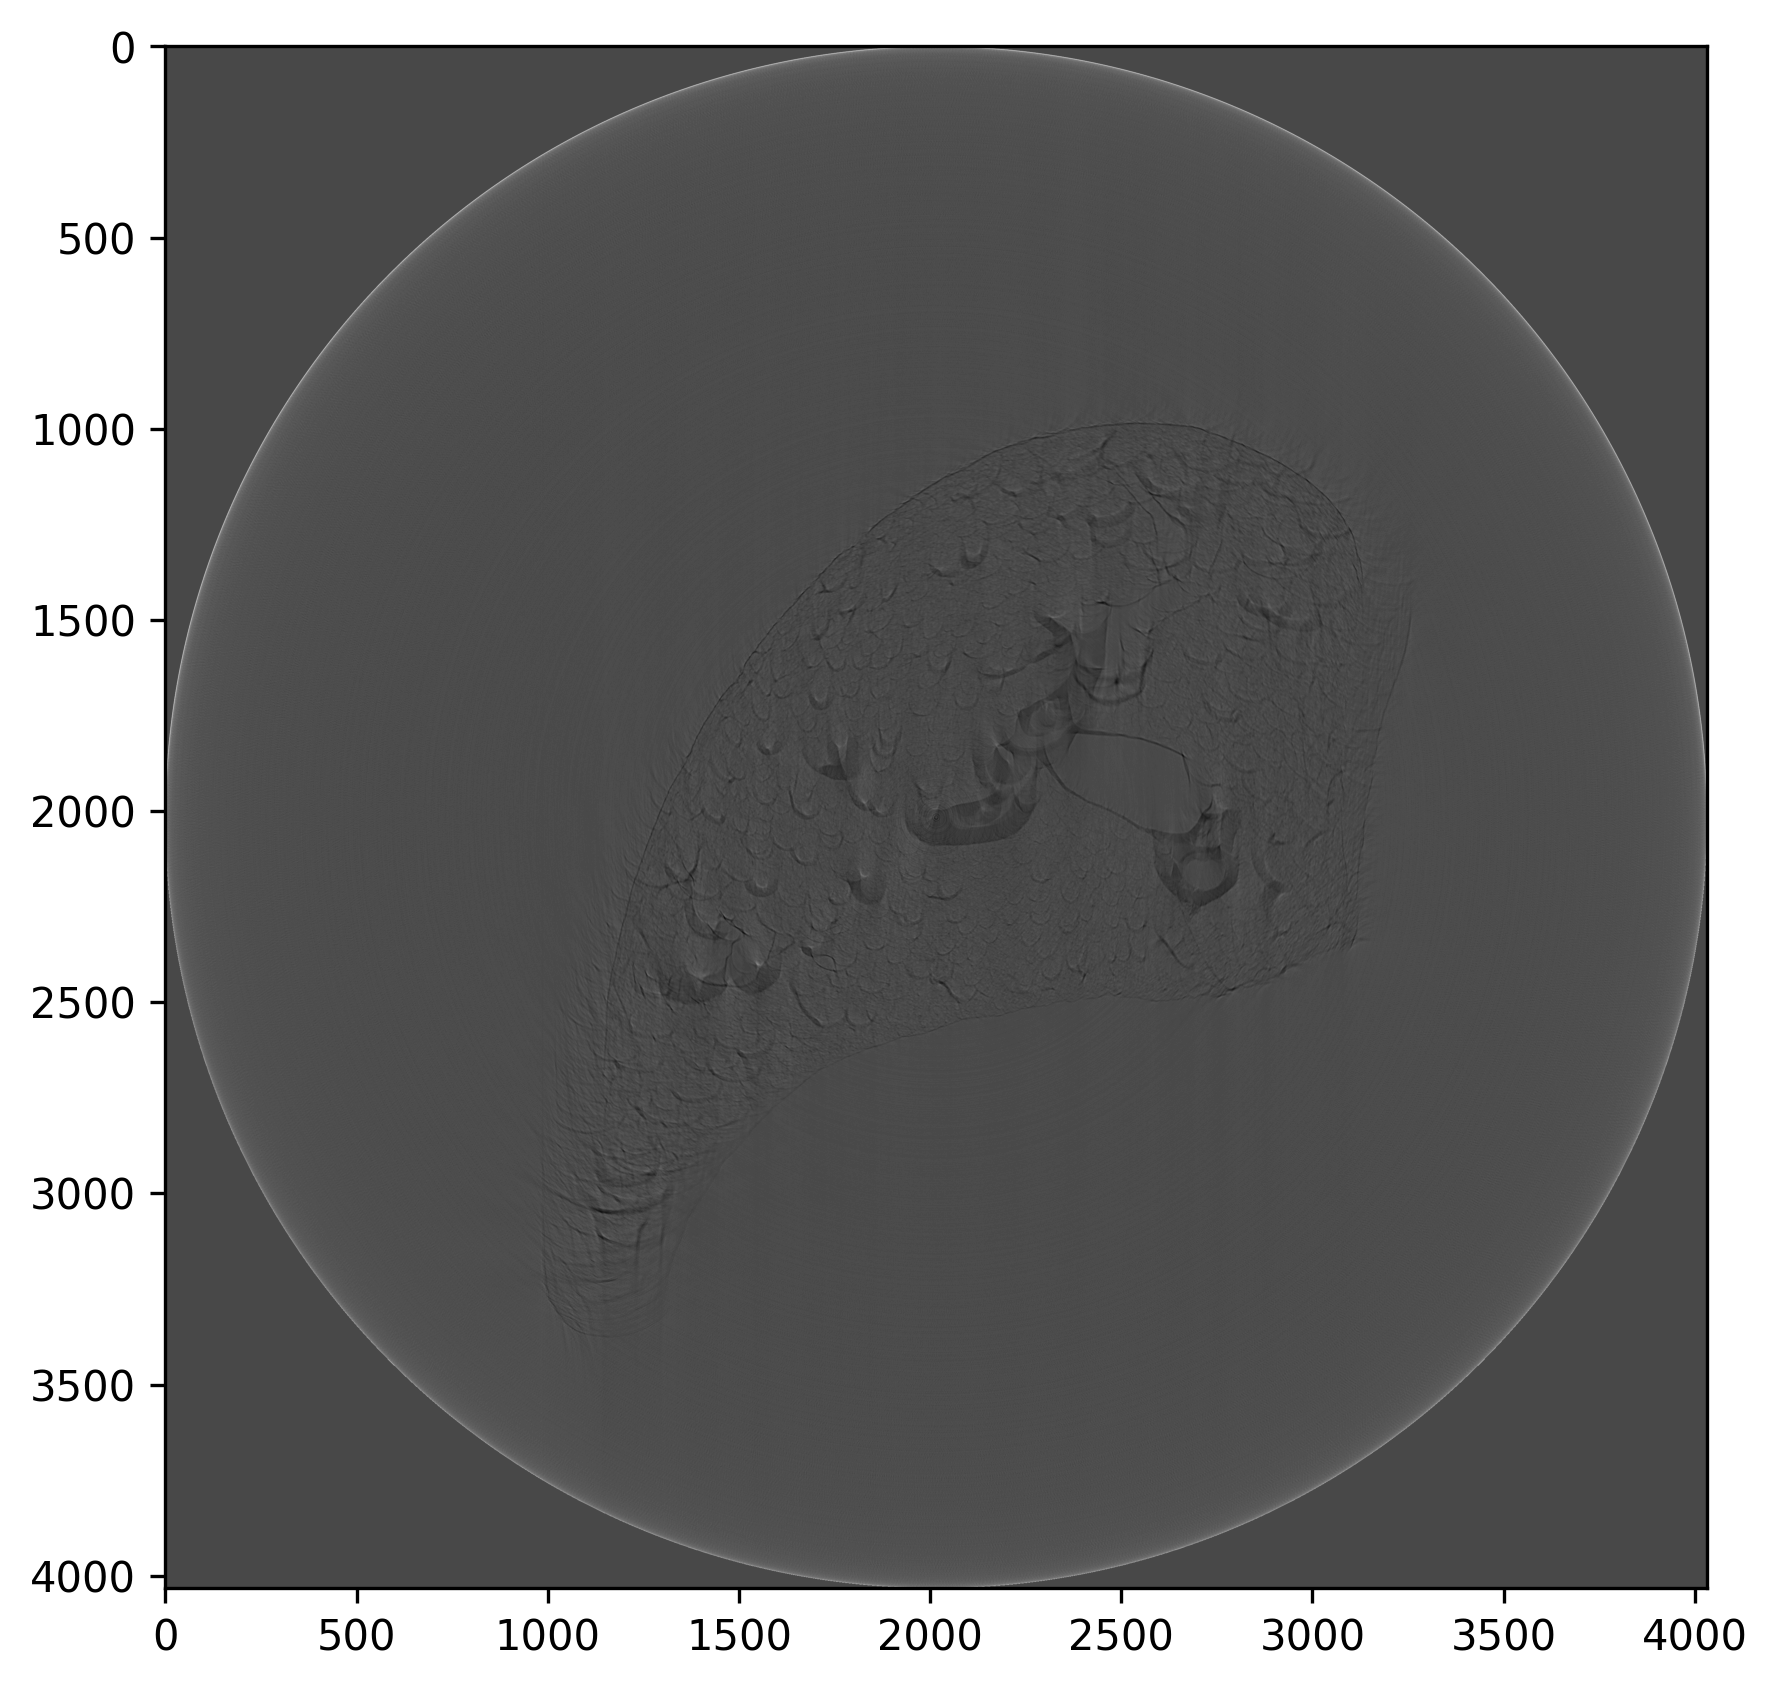

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax.imshow(RinvRu, cmap='gray')
# ax.set(xticks=[0, 1800], xticklabels=[0, 360], yticks=[0, slice_3um_skimage.shape[1]], yticklabels=[0, 1])
# ax.set_xlabel("i")
plt.tight_layout()
# plt.title(r"$\mathcal{R}u$ (sinogram) of a slice at i = " + f"{idx_slice}")
plt.show()